In [2]:
import numpy as np
import math
import os
import random
import queue
import matplotlib.pyplot as pl

In [3]:
NP=6 #Number of processes
PAGE_SIZE=4096 #Page size in bytes
F=16 #Number of Frames
INVALID = -10
PID=0
FRAME = 1 #Used for indexing into frames
phys_mem = np.full((F,2), INVALID).astype('int32') #Initial Physical memory addresses
phys_mem

array([[-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10]])

In [4]:
def init_proc_queue():
    pq=queue.Queue(maxsize=NP)
    proc_queue=list(set((NP*np.random.random(20)).astype('int32')))
    random.shuffle(proc_queue)
    for pr in proc_queue:
        pq.put_nowait(pr)
        
    print(proc_queue)
init_proc_queue()

[3, 0, 5, 1, 4, 2]


In [5]:
def correct_refs(alist,cent,maxpg):
    if cent!=0:
        pgnum=int(cent/PAGE_SIZE)
        lh=(pgnum+1)*PAGE_SIZE-1
        ll=pgnum*PAGE_SIZE
    else:
        lh=maxpg*PAGE_SIZE
        ll=0
        
    for i in range(alist.shape[0]):
        if alist[i]>=lh:
            alist[i]=lh-1
        if alist[i]<ll:
            alist[i]=ll+1
    return alist

def sim_process(M,sigma,outfile,lfrac=0.9):
    cur_page=int(M*np.random.random()) #Generating random start page
    cur_locale=round(PAGE_SIZE*(cur_page+0.5)) #Generating location of current page
    sum_refs=0
    list_locales=list()
    for count in range(M):
        num_refs=int(512+(PAGE_SIZE-512)*np.random.random())
        sum_refs+=num_refs
        list_locales.append(cur_page)
        num_loc=round(lfrac*num_refs)
        aref_list=np.random.normal(cur_locale,sigma*300+100,num_loc)
#         aref_list=correct_refs(aref_list,cur_locale,M)
        aref_list=aref_list.astype('int32')
        cur_page=int(M*np.random.random())
        cur_locale=round(PAGE_SIZE*(cur_page+0.5))
        num_trans=round((1-lfrac)*num_refs)
        tref_list=np.random.random(num_trans)*cur_locale
#         tref_list=correct_refs(tref_list,0,M)
        tref_list=tref_list.astype('int32')
        np.append(aref_list,tref_list).tofile(outfile,sep='\n')
        outfile.write('\n')
    return list_locales,sum_refs
        
      
    print('Current Page',cur_page)
    print('Current Location',cur_locale)
    print('List of Locations',list_locales)
    
npg = int(np.random.normal(10,2.5))
nsig = int(5 * np.random.random())    
fname = 'AR_' + '{:02d}'.format(0) + '.txt'
fname=open(fname,'w')
sim_process(npg,nsig,fname)

([7, 5, 3, 4, 3, 3, 6, 3, 8], 20499)

In [6]:
int(512+(PAGE_SIZE-512)*np.random.random())

4042

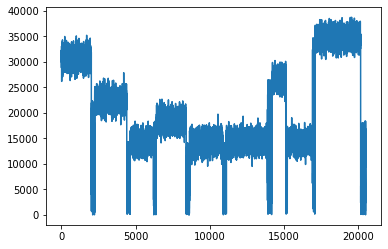

In [7]:
file=np.loadtxt('AR_00.txt')
pl.plot(file)

In [8]:
pr_size=np.zeros(NP,dtype='int32')

for p in range(NP):
    fname='AR_'+'{:02d}'.format(p)+'.txt'
    op=open(fname,'w')
    npg=int(np.random.normal(10,2.5))
    nsig=int(5*np.random.random())
    print(f'Process {p} requires {npg} pages and has a quality {nsig}')
    pg_seq,pr_size[p]=sim_process(npg,nsig,op)
    print(pg_seq,pr_size[p])
    op.write('\n')
    op.close()
    print('written process',p,'to ',fname)

Process 0 requires 10 pages and has a quality 4
[7, 0, 0, 3, 7, 4, 9, 8, 9, 0] 21266
written process 0 to  AR_00.txt
Process 1 requires 9 pages and has a quality 1
[6, 7, 2, 8, 4, 6, 5, 3, 3] 21831
written process 1 to  AR_01.txt
Process 2 requires 13 pages and has a quality 4
[3, 2, 9, 5, 5, 1, 2, 11, 12, 3, 2, 8, 4] 28386
written process 2 to  AR_02.txt
Process 3 requires 11 pages and has a quality 4
[7, 1, 7, 7, 0, 3, 6, 6, 3, 2, 0] 28958
written process 3 to  AR_03.txt
Process 4 requires 9 pages and has a quality 0
[4, 0, 4, 0, 2, 4, 1, 5, 8] 21399
written process 4 to  AR_04.txt
Process 5 requires 12 pages and has a quality 0
[7, 10, 6, 3, 1, 11, 7, 1, 5, 8, 4, 6] 34404
written process 5 to  AR_05.txt


21266


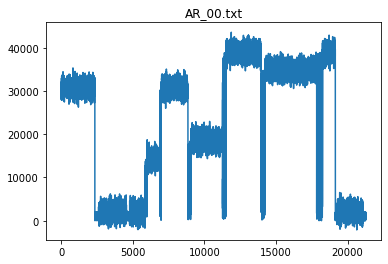

21830


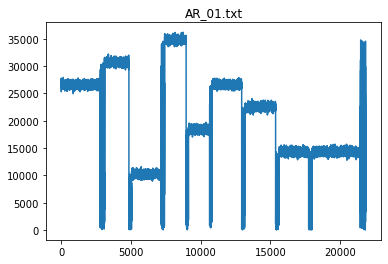

28386


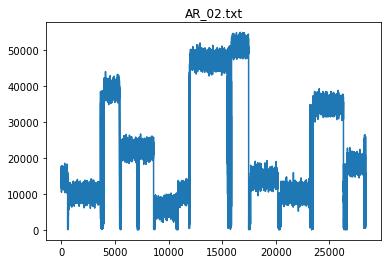

28957


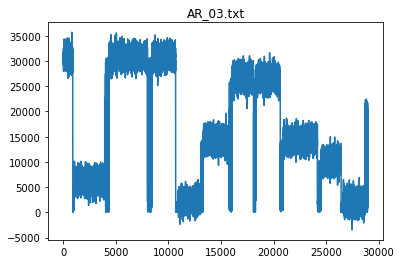

21398


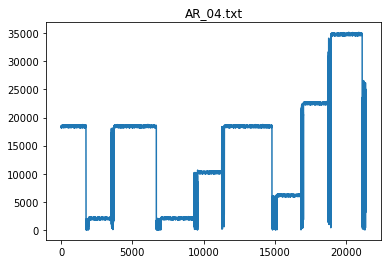

34404


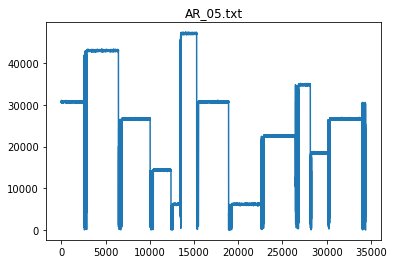

In [9]:
for p in range(NP):
    fname='AR_'+'{:02d}'.format(p)+'.txt'
    temp=np.loadtxt(fname)
    print(len(temp))
    pl.plot(range(len(temp)),temp)
    pl.title(fname)
    pl.show()

In [10]:
def init_phys_mem():
    for i in range(F):
        phys_mem[i,PID]=INVALID
        phys_mem[i,FRAME]=INVALID
        
init_phys_mem()

In [21]:
def update_phys_mem(pid):
    for i in range(F):
        if phys_mem[i,PID]==pid:
            phys_mem[i,PID]=INVALID
            phys_mem[i,FRAME]=INVALID

            
def memory_manager(infile,outfile,pid):
    num_adr=512+int(4096*np.random.random())
    idx=0
    
    while idx<num_adr:
        add_ref=infile.readline().strip()
        
        if add_ref=='':
            break #Finished reading address references
            
        add_ref=int(add_ref)  #Address reference
        pg_num=int(add_ref/PAGE_SIZE) #Page number to keep track of
        pg_offset=add_ref%PAGE_SIZE
        pg_base,pg_fault=get_pageframe(pg_num,pid)
        
        
        
        
        
    
    
    print(num_adr)
    
def get_pageframe(pnum,pr):
    fr_num=0
    while fr_num<F:
        if phys_mem[fr_num,PID]==pr and phys_mem[fr_num,FRAME]

    
memory_manager(open('AR_00.txt'),_,_)

4351
